In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import datetime as dt
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.svm import SVC
from collections import Counter
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', -1)
%matplotlib inline
import re
from sklearn.metrics import classification_report

In [90]:
mixed_tweets = pd.read_excel("./data/annotated_tweets.xlsx")
mixed_tweets = mixed_tweets[mixed_tweets['source'] == 'Twitter']
mixed_tweets = mixed_tweets[~mixed_tweets.report.isnull()]

In [91]:
mixed_tweets['report'] = mixed_tweets['report'].apply(to_lowercase)
mixed_tweets['report'] = mixed_tweets['report'].apply(remove_mentions)
mixed_tweets['report'] = mixed_tweets['report'].apply(remove_url)
mixed_tweets['report'] = mixed_tweets['report'].apply(remove_retweet)
mixed_tweets['report'] = mixed_tweets['report'].apply(remove_symbols)
mixed_tweets['report'] = mixed_tweets['report'].apply(remove_extra_spaces)

In [131]:
corpus = mixed_tweets['report'].tolist()
vectorizer = CountVectorizer(strip_accents='ascii', ngram_range=(2,2), stop_words='english')
X = vectorizer.fit_transform(corpus)
X = X.toarray()
ngram_df = pd.DataFrame(X, columns=vectorizer.get_feature_names(), index=mixed_tweets.index)

In [132]:
mixed_tweets.shape

(1864, 11)

In [133]:
freq_uni = list(ngram_df.sum().sort_values(ascending=False).index[:500])

In [134]:
data = ngram_df[freq_uni]
data['label'] = mixed_tweets['relevant']
relevant_tweets = data[data.label == 'Y']
irrelevant_tweets = data[data.label != 'Y']

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [135]:
rset = relevant_tweets.sample(100)
irset = irrelevant_tweets.sample(100)
rset['label'] = 1
irset['label'] = 0

In [106]:
# irset

In [107]:
# relevant_tweets = mixed_tweets[mixed_tweets.relevant == 'Y']
# irrelevant_tweets = mixed_tweets[mixed_tweets.relevant != 'Y']
# rset = relevant_tweets.sample(100)
# irset = irrelevant_tweets.sample(100)
# rset['label'] = 1
# irset['label'] = 0

In [136]:
data = pd.concat([rset, irset])
data['label'] = data['label'].astype('int')
# tweet_counter = Counter(data['author'])

In [69]:
def get_author_count(author):
    return tweet_counter[author]
def to_lowercase(text):
    return text.lower()
def remove_mentions(text):
    return re.sub(r'@\w+', '', text)
def remove_url(text):
    return re.sub(r'http.?://[^\s]+[\s]?', '', text)
def remove_retweet(text):
    return re.sub(r'^rt', '', text)
def remove_extra_spaces(text):
    text = re.sub(r'\w+:\/\/\S+', '', text)
    return text
def remove_symbols(text):
#     return re.sub(r'[^0-9A-Za-z \t]','', text)
    return re.sub(r'[^A-Za-z \t]','', text)

In [28]:
data['report'] = data['report'].apply(to_lowercase)
data['report'] = data['report'].apply(remove_mentions)
data['report'] = data['report'].apply(remove_url)
data['report'] = data['report'].apply(remove_retweet)
data['report'] = data['report'].apply(remove_symbols)
data['report'] = data['report'].apply(remove_extra_spaces)

In [6]:
# data[['report']]

In [7]:
data['num_tweets'] = data['author'].apply(get_author_count)

In [8]:
data['minute'] = data['authored_at'].dt.minute
data['hour'] = data['authored_at'].dt.hour
data['day'] = data['authored_at'].dt.dayofweek

In [9]:
time_df = pd.DataFrame(index = data.index)
minutes_in_day = 24*60
time_df['sin_min'] = np.sin(2*np.pi*data['minute']/minutes_in_day)
time_df['cos_min'] = np.cos(2*np.pi*data['minute']/minutes_in_day)
time_df['sin_hour'] = np.sin(2*np.pi*data['hour']/24)
time_df['cos_hour'] = np.cos(2*np.pi*data['hour']/24)
time_df['sin_day'] = np.sin(2*np.pi*data['day']/7)
time_df['cos_day'] = np.cos(2*np.pi*data['day']/7)

In [10]:
# X = pd.concat([ngram_df,time_df], axis=1)

In [11]:
# time_df.index == ngram_df.index

In [57]:
corpus = data.report.tolist()
vectorizer = CountVectorizer(strip_accents='ascii', ngram_range=(3,3), stop_words='english')
X = vectorizer.fit_transform(corpus)
X = X.toarray()
ngram_df = pd.DataFrame(X, columns=vectorizer.get_feature_names(), index=data.index)

In [58]:
# X = pd.concat([ngram_df,time_df,data[['num_tweets']]], axis=1)
X = pd.concat([ngram_df], axis=1)

In [120]:
# data.iloc[:,-1]

In [137]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-1].to_numpy(), data.iloc[:,-1].to_numpy(), test_size=0.3, random_state=0)

In [138]:
X_train.shape

(140, 500)

In [139]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [140]:
y_pred = clf.predict(X_test)

In [141]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.84      0.80        31
           1       0.81      0.72      0.76        29

    accuracy                           0.78        60
   macro avg       0.79      0.78      0.78        60
weighted avg       0.79      0.78      0.78        60



In [142]:
ord_features = np.argsort(clf.coef_[0])[::-1]
features = data.columns[:-1]
xlabels = []
for idx in ord_features:
#     print(features[idx])
    xlabels.append(features[idx])

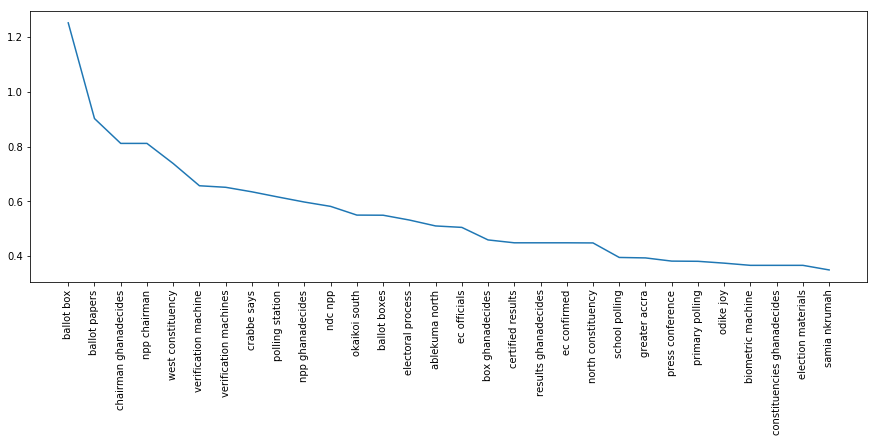

In [143]:
n = 30
plt.figure(figsize=(15,5))
plt.plot(np.sort(clf.coef_[0])[::-1][:n])
plt.xticks(np.arange(n), xlabels[:n], rotation='vertical')
plt.show()

In [129]:
clf.coef_[0][-1]

0.0